# Facial Recognition and Reconstruction with Principal Component Analysis (PCA)
---

The purpose of this notebook is to walk through the linear algebra concepts required to perform principal component analysis. By the end of the notebook, you will have an understanding on what eigenfaces are, how they function, and how they can be utilized to reduce the amount of data required to store information.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

### Step 1: Load the Dataset

All 400 of our face inputs are stored in the `ATTfaces/faces/` directory as `.pgm` files. We'll put all of these images into an array, enabling us to compute calculations on the images.

Once we have our images in an easy-to-compute format, we'll display a few to show what type of information we're working with.

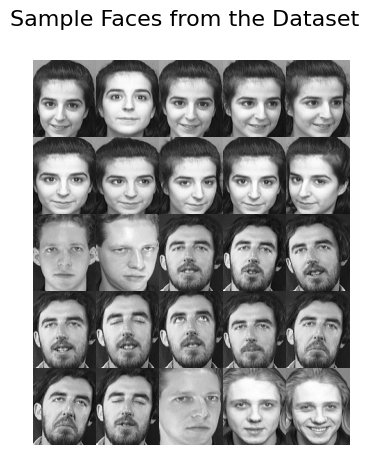

In [2]:
# Load raw images
data_dir = "ATTfaces/faces/"
file_names = os.listdir(data_dir)
images = [np.asarray(Image.open(data_dir + file_names[i])) for i in range(len(file_names))]
images = np.array(images)

# Visualize some of the faces
fig = plt.figure(figsize=(5, 5))
fig.suptitle("Sample Faces from the Dataset", fontsize=16)
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0)

for ax, im in zip(grid, images[:25]):
    ax.imshow(im, cmap="gray")
    ax.axis('off')

plt.show()

### Step 2: Calculate the Mean Face

Now that we have all of the faces loaded and have seen a few, we'll calculate the mean face. The mean face is the average in the dataset across all 400 examples. Thankfully, calculating the mean isn't too tricky thanks to the libraries we're using.

Once we've caluclated the mean face, we will visualize it to see what all the dataset images have in common with one another.

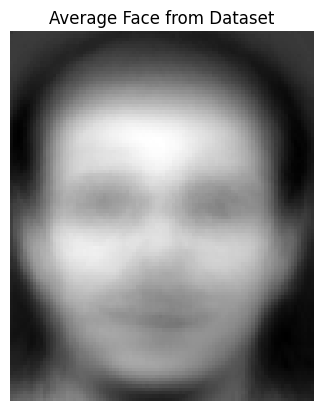

In [3]:
# Calculate the mean face
face_mean = images.mean(0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(face_mean, cmap="gray")
ax.axis('off')
ax.set_title("Average Face from Dataset")

plt.show()

# Principal Component Analysis (PCA)
---

Principal Component Analysis allows us to identify the most important aspects of the dataset (eigenfaces) and shrink each image to share similarities with those eigenfaces. While the process is lossy, we can retain almost all of the initial information, while greatly reducing the file size of the dataset.

### Step 3: Prepare for Eigendecompsition

We currently have our dataset loaded and in a workable format as well as our mean face from the dataset. Now, we'll standardize the dataset with the formula:

$$ \frac{\text{image} - \text{mean}}{\text{standard deviation}} $$

Then, we'll reshape that 3D output from the standardization into a 2D matrix. Next, we'll compute the covariance matrix. This tells us how closely related principal components are to one another.

* A positive sign indicates dependency between components
* A negative sign indicates independence between components


In [4]:
imageAmount, height, width = images.shape

# ***Subtract mean image***
dataStandardized = images - face_mean
print("Standardized Data Dimensions:", dataStandardized.shape)

# ***Vectorize the images to a 2D matrix***
dataReshape = dataStandardized.reshape(imageAmount, height * width)
print("Reshaped Data Dimensions:", dataReshape.shape)

# ***Create the covariance matrix***
matrixCovariance = np.cov(dataReshape, rowvar=True)
print("Covariance Dimensions:", matrixCovariance.shape)

Standardized Data Dimensions: (400, 112, 92)
Reshaped Data Dimensions: (400, 10304)
Covariance Dimensions: (400, 400)


### Step 4: Eigendecomposition

In this step, we will compute the eigenvalues and eigenvectors. While the computation will be done by a function call to the NumPy library, it's important to know what these output variables are.

Eigenvectors of the covariance matrix are the vector directions that achieve the most variance and therefore the most information about the initial information. These vectors are known as the **principal components** of the dataset.

The eigenvalues are the coefficients that retain the amount of variance from each principal component.

The eigenvectors and eigenvalues have a $1:1$ relationship because an eigenvalue is necessary to rank the eigenvecotrs in highest - lowest order.

In [5]:
# ***Compute the eigendecomposition***
print("finding eigenvalues and eigenvectors")
eigenvalues, eigenvectors = np.linalg.eig(matrixCovariance)


finding eigenvalues and eigenvectors


### Step 5:  Eigenfaces and Normalization

Currently, we have 400 eigenvectors and eigenvalues because that's the dimensionality of our covariance matrix. To reduce the size of our dataset, we'll only keep the first 150 values.

* Sort the data in highest - lowest order.
* Matrix mulitply the top 150 eigenvectors by the 2D representation of our data (`dataReshape`).
* Normalize the eigenfaces to squeeze the values to be between 0 and 1.
* Compute weights by finding the matrix multiplication of `dataReshape` and `eiugenfaces` (needed for reconstruction)

In [ ]:
n_comps = 150

# ***Sort eigenvectors and keep most important ones***
dataSorted = np.argsort(-eigenvalues)[:n_comps]
eigenvalues = eigenvalues[dataSorted]
eigenvectors = eigenvectors[:, dataSorted]
print("Eigenvectors Dimensions:", eigenvectors.shape)

# ***Calculate eigenfaces***
eigenfaces = dataReshape.T @ eigenvectors
print("Eigenfaces Dimensions:", eigenfaces.shape)

# ***Normalize eigenfaces***
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# ***Compute the weights***
weights = dataReshape @ eigenfaces
print("Weights Dimensions", weights.shape)

eigenfaces = eigenfaces.T

Eigenvectors Dimensions: (400, 200)
Eigenfaces Dimensions: (10304, 200)
Weights Dimensions (400, 200)


### Step 6: Displaying Eigenfaces

We will show print out the top 16 eigenfaces from the 150 we computed.

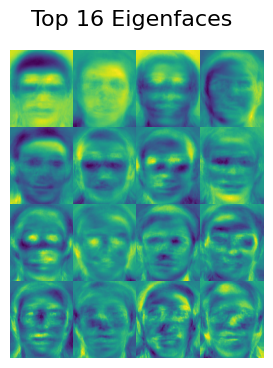

In [12]:
# Visualize some eigenfaces
fig = plt.figure(figsize=(4, 4))
fig.suptitle("Top 16 Eigenfaces", fontsize=16)
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0)

for ax, im in zip(grid, eigenfaces[:16]):
    ax.imshow(im.reshape(height, width))
    ax.axis('off')

plt.show()

### Step 7: Reconstructing the image

Using the eigenfaces we just calculated and the image weights, we can reconstruct images with those eigenfaces and weights.

In [14]:
idx = np.random.randint(400)

# Find weights for the image and number of eigenfaces
imageWeights = weights[idx, :n_comps]
print("Image Weights Dimensions", imageWeights.size)

# Find the eigenfaces selected for reconstruction
eigenfacesSelected = eigenfaces[:n_comps, :]
print("Eigenfaces Selected Dimensions", eigenfacesSelected.size)

# Reconstruct the image
reconstruct = imageWeights @ eigenfacesSelected
print("Reconstructed Dimensions", reconstruct.size);

# Add mean back to the image!
reconstruct += face_mean.reshape(-1)

# Reshape back into 2D
reconstructed_img = reconstruct.reshape([height, width])
print("Recovered Image Dimensions", reconstructed_img.size)

Image Weights Dimensions 200
Eigenfaces Selected Dimensions 2060800
Reconstructed Dimensions 10304
Recovered Image Dimensions 10304


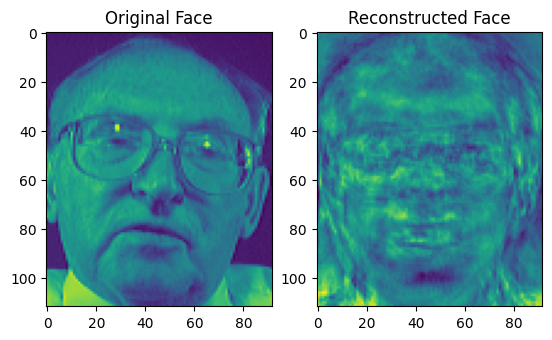

In [15]:
# Visualize original and reconstructed
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(images[idx])
ax2.imshow(reconstructed_img)
ax1.set_title("Original Face")
ax2.set_title("Reconstructed Face")

plt.show()